In [32]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from torch.nn.functional import cross_entropy
import torch.nn as nn
from sklearn.metrics import f1_score 

! Experiment with main transform

In [33]:
img_resize = 255
img_crop = 225
main_transform = transforms.Compose([transforms.Resize(img_resize),
                                transforms.CenterCrop(img_crop),
                                transforms.ToTensor()])


pil_transform = transforms.ToPILImage()

! Data loading

In [ ]:
train_dir_path = 'train/simpsons_dataset'
test_dir_path = 'testset'

train_dataset = datasets.ImageFolder(train_dir_path, transform=main_transform)
test_dataset = datasets.ImageFolder(test_dir_path, transform=main_transform)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

! Checking balance

! Creating a dict to cor labels and simpsons names

In [62]:
dic = {}
#labels = {}
for img, label in train_dataset.imgs:
    class_label = img[img.index('t/') + 2: img.index('/', img.index('t/') + 2)]
    dic[label] = class_label
    labels[label] += 1
print(labels)

{0: 913, 1: 42, 2: 623, 3: 106, 4: 1342, 5: 98, 6: 1193, 7: 986, 8: 47, 9: 469, 10: 13, 11: 457, 12: 27, 13: 27, 14: 121, 15: 2246, 16: 498, 17: 1207, 18: 310, 19: 3, 20: 1354, 21: 128, 22: 1291, 23: 71, 24: 246, 25: 1079, 26: 17, 27: 1452, 28: 1454, 29: 358, 30: 32, 31: 72, 32: 1194, 33: 65, 34: 45, 35: 89, 36: 103, 37: 877, 38: 40, 39: 55, 40: 8, 41: 181}


! Plotting balance hist

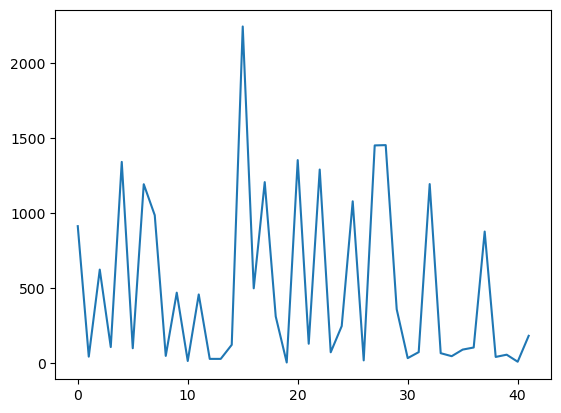

In [77]:
#plt.hist(list(labels.values()), bins=2)
plt.plot(np.arange(42), labels.values())
plt.show()

! Features & classes. RN weights also

In [36]:
features = 3 * 225 * 225
classes = 42

#W = torch.rand(features, classes) * 15
#print(W.shape)
#W.requires_grad_()

! Gigachad model.

In [23]:
from torch import nn, optim
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 10, 6, stride=1)  # out = 10 x 220 x 220
        #self.max_pool2d = F.max_pool2d(kernel_size=2)   # out = 10 x 110 x 110
        self.conv2 = nn.Conv2d(10, 20, 5, stride=1) # out = 20 x 106 x 106
        #self.avg_pool2d = F.avg_pool2d(kernel_size=2) # out = 20 x 53 x 53
        self.conv3 = nn.Conv2d(20, 25, 4, stride=1)   # out = 25 x 50 x 50
        #self.mega_pool2d = F.avg_pool2d(kernel_size=5) # out = 25 x 10 x 10
        self.fc1 = nn.Linear(25 * 10 * 10, 300)
        self.fc2 = nn.Linear(300, 126)
        self.fc3 = nn.Linear(126, 42)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.avg_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.avg_pool2d(F.relu(self.conv3(x)), kernel_size=5)
        #x = x.view(x.shape[0], -1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        #x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = Model()

In [58]:
from torch import nn, optim
import torch.nn.functional as F 


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride = 3)  # (3, 225, 225) -> (6, 75, 75) bottleneck?
        self.conv2 = nn.Conv2d(6, 12, 6, stride = 1)  # (6, 25, 25) -> (12, 20, 20)
        self.fc1 = nn.Linear(12 * 10 * 10, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 42)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), kernel_size = 3) # out (6, 25, 25)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2) # out (12, 10, 10)
        ### Fully-Connected layers
        x = self.flatten(x)  # flattening [64, 12, 10, 10] into? [64, 1200]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        
        return logits
    
model = Model()

In [43]:
model

Model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(3, 3))
  (conv2): Conv2d(6, 12, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=1200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=42, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

! aux funcs

In [44]:
def softmax(logits):
    probs = torch.exp(logits)/torch.exp(logits).sum(axis = 1, keepdims=True)
    return probs

! Training

In [45]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) в своей основе применительно к логитам (logits)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.9, 0.99))

In [46]:
epochs = 10
history = []

In [48]:
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        print("#", end="")
        logits = model(x_batch)
        #probs = softmax(logits)
        
        loss = criterion(logits, y_batch)
        history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #input()
    print(f"epoch {epoch + 1}, loss {loss}")

#######################################################################################################################################################################################################################################################################################################################################epoch 1, loss 2.4748642444610596
#######################################################################################################################################################################################################################################################################################################################################epoch 2, loss 2.160294532775879
#########################################################################################################################################################################################################################################################################################

In [49]:
print(len(history))

3276


Additional fine-tuning

In [55]:
add_epochs = 15
for epoch in range(add_epochs):
    for x_batch, y_batch in train_loader:
        print("*", end="")
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch + 41} loss: {loss}")
        

***************************************************************************************************************************************************************************************************************************************************************************************************************************************epoch 41 loss: 0.18351100385189056
***************************************************************************************************************************************************************************************************************************************************************************************************************************************epoch 42 loss: 0.09673672914505005
************************************************************************************************************************************************************************************************************************************************************************************

In [56]:
print(len(history))

18011


! Plting

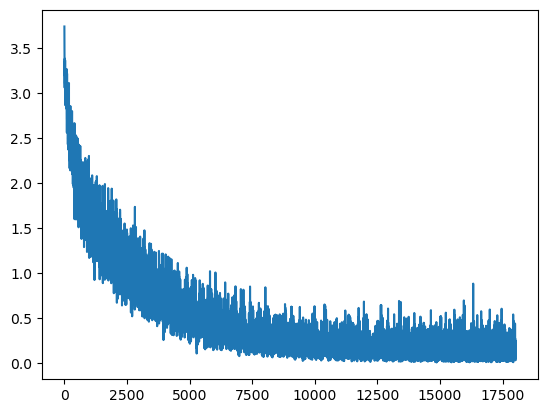

In [57]:
plt.plot(np.arange(18011), history)
plt.show()

! Compute predicted classes for train dataset

In [60]:
predictions = np.array([])
smx = nn.Softmax(dim=1)  # logits -> prb distr
for x_batch, y_batch in train_loader:
    #print(x_batch.shape)
    #x_batch = x_batch.view(x_batch.shape[0], -1)
    logits = model(x_batch)
    probs = torch.exp(logits)/torch.exp(logits).sum(axis = 1, keepdims=True)
    pred = torch.argmax(probs, dim=1)
    predictions = np.hstack((predictions, *pred))
    #print(predictions)
    print(predictions.shape, end=" ")
    
    #print(pred)
    #print(pred.shape)
    #input()
print(predictions.shape)
print(np.unique(predictions))

(64,) (128,) (192,) (256,) (320,) (384,) (448,) (512,) (576,) (640,) (704,) (768,) (832,) (896,) (960,) (1024,) (1088,) (1152,) (1216,) (1280,) (1344,) (1408,) (1472,) (1536,) (1600,) (1664,) (1728,) (1792,) (1856,) (1920,) (1984,) (2048,) (2112,) (2176,) (2240,) (2304,) (2368,) (2432,) (2496,) (2560,) (2624,) (2688,) (2752,) (2816,) (2880,) (2944,) (3008,) (3072,) (3136,) (3200,) (3264,) (3328,) (3392,) (3456,) (3520,) (3584,) (3648,) (3712,) (3776,) (3840,) (3904,) (3968,) (4032,) (4096,) (4160,) (4224,) (4288,) (4352,) (4416,) (4480,) (4544,) (4608,) (4672,) (4736,) (4800,) (4864,) (4928,) (4992,) (5056,) (5120,) (5184,) (5248,) (5312,) (5376,) (5440,) (5504,) (5568,) (5632,) (5696,) (5760,) (5824,) (5888,) (5952,) (6016,) (6080,) (6144,) (6208,) (6272,) (6336,) (6400,) (6464,) (6528,) (6592,) (6656,) (6720,) (6784,) (6848,) (6912,) (6976,) (7040,) (7104,) (7168,) (7232,) (7296,) (7360,) (7424,) (7488,) (7552,) (7616,) (7680,) (7744,) (7808,) (7872,) (7936,) (8000,) (8064,) (8128,) 

In [ ]:
! Labeling whole train_loader 

In [69]:
y = np.array([])
for x_batch, y_batch in train_loader:
    y = np.hstack((y, *y_batch))
    #print(y.shape)
    print("#",end="")
print()
print(y.shape)
print(y[0:50])

#######################################################################################################################################################################################################################################################################################################################################
(20928,)
[15.  7. 15. 15. 22. 15.  6. 14. 27. 37. 15. 14. 28.  7. 11. 28. 32. 15.
 15.  0. 15. 32. 25. 28. 28.  6.  5. 27. 37. 32. 22.  2. 15. 17.  7.  9.
 32.  4.  2.  2.  0. 27.  4.  7. 16. 37. 27. 16. 32. 22.]


In [73]:
f1 = f1_score(y, predictions, average='weighted')
print(f1)

0.0033593812868031444


! Convert [0, 1, 2] to ['bart', 'marg', 'maggi']

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu/.ipynb_checkpoints', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown/.ipynb_checkpoints', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz']


! Testing

In [74]:
preds = np.array([])

In [75]:

for x_batch, y_batch in test_loader:
    #x_batch = x_batch.view(x_batch.shape[0], -1)
    logits = model(x_batch)
    probs = torch.exp(logits)/torch.exp(logits).sum(axis = 1, keepdims=True)
    pred = torch.argmax(probs, dim=1)
    preds = np.hstack((preds, *pred))
print('done')

done


In [76]:
ans_preds = preds.copy()
print(ans_preds[:30])
ans_preds = ans_preds.tolist()
for elem in range(len(ans_preds)):
    ans_preds[elem] = dic[ans_preds[elem]]
print(ans_preds[:30])

[38. 38. 38. 38. 37. 38. 38. 38. 38. 37. 37. 38. 37. 38. 38. 38. 38. 38.
 38. 38. 38. 38. 38. 37. 38. 38. 37. 38. 38. 38.]
['sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_bob', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_bob', 'sideshow_bob', 'sideshow_mel', 'sideshow_bob', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel', 'sideshow_bob', 'sideshow_mel', 'sideshow_mel', 'sideshow_bob', 'sideshow_mel', 'sideshow_mel', 'sideshow_mel']


! Creating ids

In [40]:
i = 0
ids = []
for img, label in test_dataset.imgs:
    #print(img, label)
    ids.append('img' + str(i) +'.jpg')
    i += 1
    #if i > 990: break
print('done')

done


! Cut /.ipynb files from test_dataset

In [41]:
ans_preds = ans_preds[:991]
ids = ids[:991]
print(ids[-1], ans_preds[-1])

img990.jpg krusty_the_clown


! sea bottom predict

! Output file

In [76]:
import pandas as pd

print(np.array(ans_preds).shape)
print(np.array(ids).shape)
input()
ans_preds = np.array(ans_preds).T
ids = np.array(ids).T
print(ans_preds)
final = np.vstack((ids, ans_preds))
print(final[:10][:])
subm = pd.DataFrame(final, columns=['ImageId', 'Expected'])

(991,)
(991,)


KeyboardInterrupt: Interrupted by user

! Submission file

In [52]:
a = np.savetxt(
    'submission.csv',
    np.rec.fromarrays([ids, ans_preds]),
    fmt=['%s', '%s'],
    delimiter=',',
    header='Id, Expected',
    comments='',
)
a = pd.read_csv('submission.csv')
a.to_csv('sub2.csv', index=False)

In [44]:
import pandas as pd
ser1 = pd.Series(ids)
ser2 = pd.Series(ans_preds)

df = pd.concat([ser1, ser2], axis = 1)
df = df.rename(columns={0: 'Id', 1: 'Expected'})
df.to_csv('sub5.csv', index=False)
#print(df.head())

In [196]:
def bgr_to_rgb(tnsr):
    # switch bgr to rgb.
    return tnsr#[:, :, [1, 2, 0]]

In [215]:
def load_images_from_folder(folder):
    images = []
    images_rgb = []
    i = 0
    dic = {}
    for filename in os.listdir(folder):
        dic[filename] = 0
        i +=1
        img = cv2.imread(os.path.join(folder,filename), 1)
        if img is not None:
            img_t = torch.FloatTensor(img)
            img_t_rgb = bgr_to_rgb(img_t)
            images.append(img)
            images_rgb.append(img_t_rgb)
    for filename in os.listdir(folder):
        dic[filename] += 1
    dic = dic
    return dic

def hwc_to_chw(tnsr):
    tnsr = torch.swapaxes(tnsr, 0, 2)
    return torch.swapaxes(tnsr, 1, 2)


print(load_images_from_folder('train/simpsons_dataset'))

{'maggie_simpson': 1, 'charles_montgomery_burns': 1, '.DS_Store': 1, 'patty_bouvier': 1, 'ralph_wiggum': 1, 'chief_wiggum': 1, 'milhouse_van_houten': 1, 'rainier_wolfcastle': 1, 'cletus_spuckler': 1, 'martin_prince': 1, 'lenny_leonard': 1, 'sideshow_bob': 1, 'fat_tony': 1, 'selma_bouvier': 1, 'barney_gumble': 1, 'lionel_hutz': 1, 'gil': 1, 'moe_szyslak': 1, 'carl_carlson': 1, 'edna_krabappel': 1, 'snake_jailbird': 1, 'groundskeeper_willie': 1, 'sideshow_mel': 1, 'ned_flanders': 1, 'abraham_grampa_simpson': 1, 'krusty_the_clown': 1, 'waylon_smithers': 1, 'apu_nahasapeemapetilon': 1, 'marge_simpson': 1, 'comic_book_guy': 1, 'nelson_muntz': 1, 'mayor_quimby': 1, 'kent_brockman': 1, 'professor_john_frink': 1, 'principal_skinner': 1, 'bart_simpson': 1, 'lisa_simpson': 1, 'otto_mann': 1, 'troy_mcclure': 1, 'miss_hoover': 1, 'disco_stu': 1, 'homer_simpson': 1, 'agnes_skinner': 1}


In [60]:
class TestImgs(Dataset):
   def __init__(self,remove_list):
        self.cifar10 = datasets.CIFAR10(root='./data',

                                        download=False,
                                        train=True,
                                        transform=transforms.ToTensor())
        self.data = self.cifar10.data
        self.targets = self.cifar10.targets
        self.final_data, self.final_targets = self.__remove__(remove_list)
      
    def __getitem__(self, index):
        data, target = self.final_data[index], self.final_targets[index]
        return data, target, index

    def __len__(self):
        return len(self.final_data)

    def __remove__(self, remove_list):
        data = np.delete(self.data, remove_list)
        targets = np.delete(self.targets, remove_list)
        return data, targets

In [65]:
for images, labels in iter(test_loader):
    img = pil_transform(images[0])
    img.show()
    input()
images, labels = next(iter(test_loader))
img = pil_transform(images[0])
print(img, labels)
images, labels = next(iter(test_loader))
img = pil_transform(images[0])
print(img, labels)
img.show()
images, labels = next(iter(test_loader))
img = pil_transform(images[0])
img.show()

 a
 s
 b


KeyboardInterrupt: Interrupted by user